Run PCA on different model neural population trajectories generated by natural song

In [24]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA

from aux import zscore
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NR = 224  # original number of responses
NTR = 276  # number of trials

NRL_MDLS = ['lin', 'ln', 'dyn']
COLORS = ['b', 'm', 'k']
FPCAS = [
    f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_pca_nm91_zh23/pca_results.npy'
    for nrl_mdl in NRL_MDLS
]

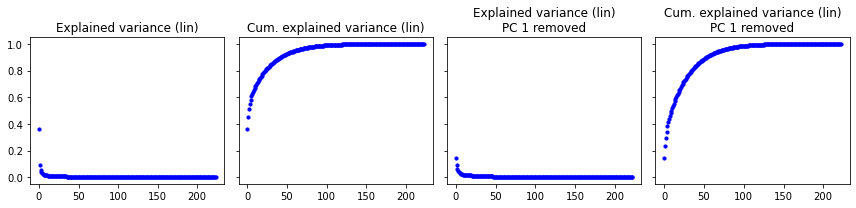

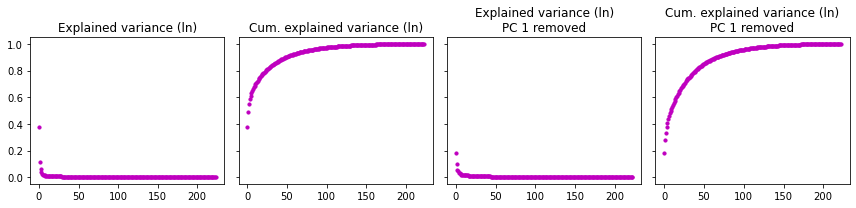

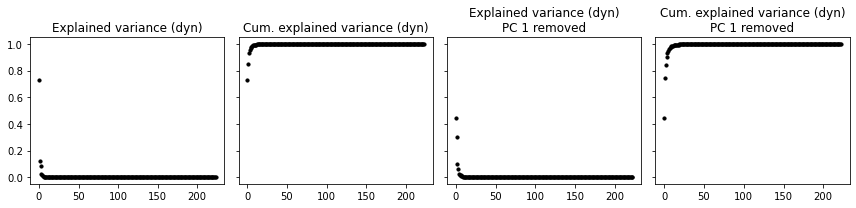

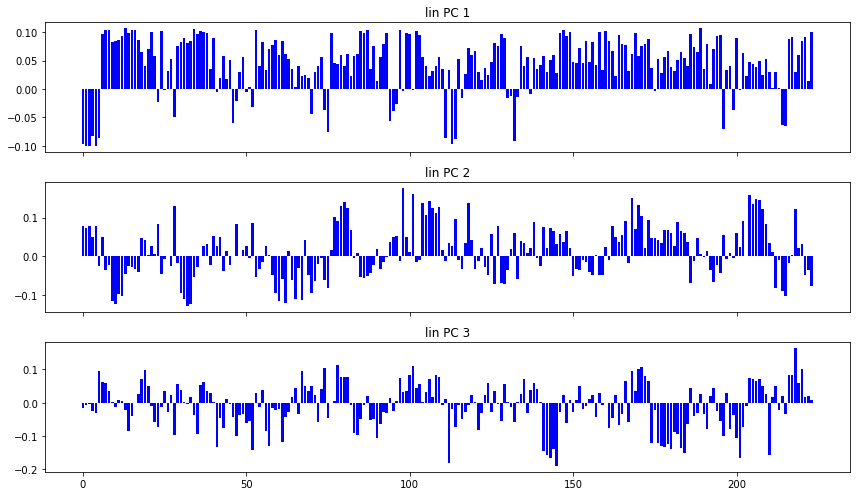

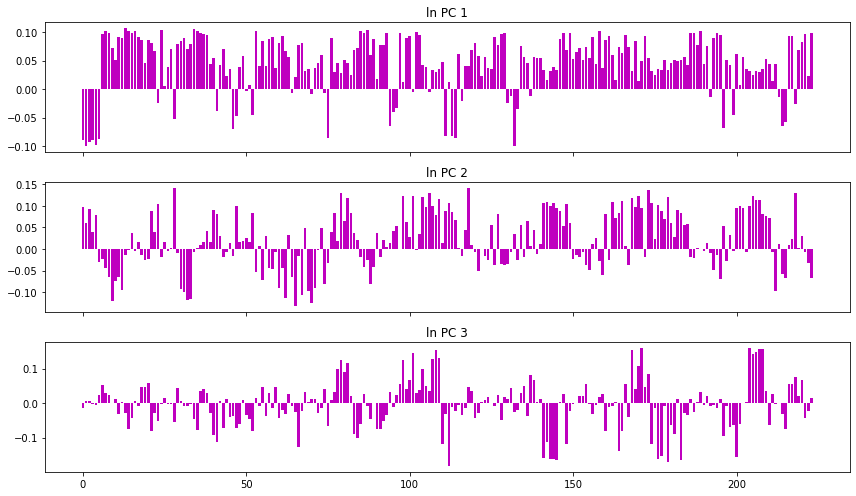

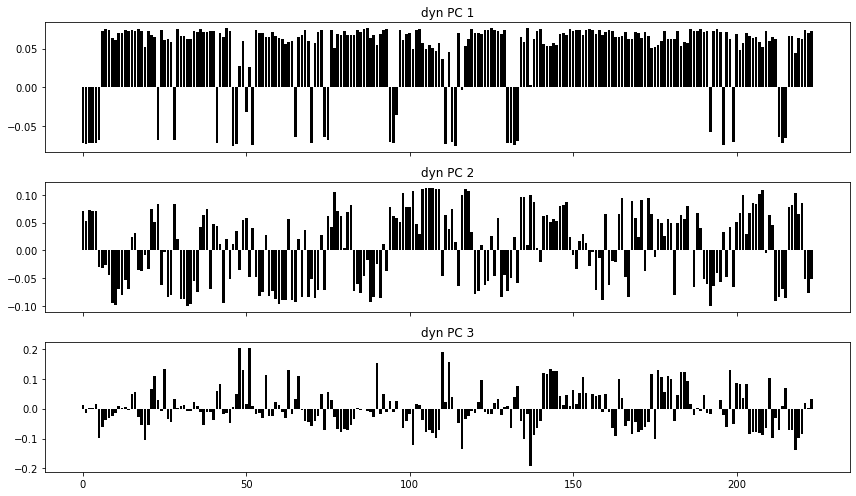

In [30]:
# plot PCA eigenspectra results for each nrl mdl
for nrl_mdl, color, fpca in zip(NRL_MDLS, COLORS, FPCAS):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True, sharey=True)
    pca_rslt = np.load(fpca, allow_pickle=True)[0]
    expl_var = pca_rslt['expl_var']
    axs[0].scatter(np.arange(len(expl_var)), expl_var, s=10, c=color)
    axs[0].set_title(f'Explained variance ({nrl_mdl})')
    axs[1].scatter(np.arange(len(expl_var)), expl_var.cumsum(), s=10, c=color)
    axs[1].set_title(f'Cum. explained variance ({nrl_mdl})')
    
    expl_var_no_pc_1 = expl_var[1:]
    expl_var_no_pc_1 /= expl_var_no_pc_1.sum()
    
    axs[2].scatter(np.arange(len(expl_var_no_pc_1)), expl_var_no_pc_1, s=10, c=color)
    axs[2].set_title(f'Explained variance ({nrl_mdl})\nPC 1 removed')
    axs[3].scatter(np.arange(len(expl_var_no_pc_1)), expl_var_no_pc_1.cumsum(), s=10, c=color)
    axs[3].set_title(f'Cum. explained variance ({nrl_mdl})\nPC 1 removed')
    
# plot top PCs for each nrl mdl
top_pcs = {}
for nrl_mdl, color, fpca in zip(NRL_MDLS, COLORS, FPCAS):
    fig, axs = plt.subplots(3, 1, figsize=(12, 7), tight_layout=True, sharex=True)
    pca_rslt = np.load(fpca, allow_pickle=True)[0]
    
    for cpc, ax in enumerate(axs):
        ax.bar(np.arange(NR), pca_rslt['pcs'][cpc, :], color=color)
        ax.set_title(f'{nrl_mdl} PC {cpc+1}')
    
    top_pcs[nrl_mdl] = pca_rslt['pcs'][:4, :]